In [ ]:
import numpy as np
import pandas as pd
import math
import matplotlib.pyplot as plt
from collections import Counter
import torch
from torch.utils.data import Dataset, DataLoader
import torch.nn as nn
import torch.nn.functional as F
from tqdm import tqdm
import os
import re
import gc

In [44]:
def load_dataset(text):
    with open(text, 'r', encoding='utf-8') as f:
        data = f.read()
    return data

text = load_dataset("Pride_and_Prejudice-Jane_Austen.txt")
print("Number of Characters = ", len(text))
print(text[:500])

Number of Characters =  711331
The Project Gutenberg eBook, Pride and Prejudice, by Jane Austen, Edited
by R. W. (Robert William) Chapman


This eBook is for the use of anyone anywhere at no cost and with
almost no restrictions whatsoever.  You may copy it, give it away or
re-use it under the terms of the Project Gutenberg License included
with this eBook or online at www.gutenberg.org





Title: Pride and Prejudice


Author: Jane Austen

Editor: R. W. (Robert William) Chapman

Release Date: May 9, 2013  [eBook #42671]

Lang


In [139]:
def tokenize(text):
    text = text.lower()
    text = re.sub(r"[^a-z0-9.,!?;:'\" \n]", "", text)
    text = re.sub(r"\s+", " ", text)
    return list(text)

tokens = tokenize(text)
print("Total tokens = ", len(tokens))

Total tokens =  701900


In [140]:
def build_vocabulary(tokens):
    counter = Counter(tokens)
    vocabulary = set(counter.keys())
    stoi = {}
    itos = {}
    
    for i, token in enumerate(sorted(vocabulary)):
        stoi[token] = i+2
    stoi["<pad>"] = 0
    stoi["<unk>"] = 1

    for s, i in stoi.items():
        itos[i] = s

    return stoi, itos

stoi, itos = build_vocabulary(tokens)

In [141]:
def numericalize(tokens, stoi):
    indices = []
    for t in tokens:
        indices.append(stoi.get(t, stoi["<unk>"]))
    return indices

ids = numericalize(tokens, stoi)

In [142]:
def train_val_split(ids, val_ratio):
    split = int(len(ids) * (1-val_ratio))
    return ids[:split], ids[split:]

train_ids, val_ids = train_val_split(ids, val_ratio=0.3)

In [ ]:
class LMDataset(Dataset):
    def __init__(self, token_ids, seq_len):
        self.token_ids = token_ids
        self.seq_len = seq_len

    def __len__(self):
        return len(self.token_ids)-self.seq_len
    
    def __getitem__(self, idx):
        x = torch.tensor(self.token_ids[idx:idx+self.seq_len], dtype=torch.long)
        y = torch.tensor(self.token_ids[idx+1:idx+self.seq_len+1], dtype=torch.long)

        return x,y


In [ ]:
def data_loader(token_ids, seq_len, batch_size, shuffle):
    dataset = LMDataset(token_ids, seq_len)
    loader = DataLoader(dataset, batch_size=batch_size, shuffle=shuffle, num_workers=2, pin_memory=True, drop_last=True)

    return loader

In [145]:
seq_len = 64
batch_size = 32

train_loader = data_loader(train_ids, seq_len, batch_size, shuffle=True)
val_loader = data_loader(val_ids, seq_len, batch_size, shuffle=False)

In [146]:
class LSTMCell(nn.Module):
    def __init__(self, input_dim, hidden_dim):
        super().__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim

        self.W = nn.Parameter(torch.randn(input_dim, 4 * hidden_dim)*0.1)
        self.U = nn.Parameter(torch.randn(hidden_dim, 4 * hidden_dim)*0.1)
        self.b = nn.Parameter(torch.zeros(4 * hidden_dim))

        for W in [self.W, self.U]:
            nn.init.xavier_uniform_(W)
    
    def forward(self, x, h, c):
        batch_size, seq_len, _ = x.size()
        hidden_outputs, cell_outputs = [], []
        
        for t in range(seq_len):
            x_t = x[:, t, :]
            gates = x_t @ self.W + h @ self.U + self.b
            forget_gate, input_gate, output_gate, activations = gates.chunk(4, dim=1)
            forget_gate = torch.sigmoid(forget_gate)
            input_gate = torch.sigmoid(input_gate)
            output_gate = torch.sigmoid(output_gate)
            activations = torch.tanh(activations)
            
            c = (forget_gate * c) + (input_gate * activations)
            h = torch.tanh(c) * output_gate

            hidden_outputs.append(h.unsqueeze(1))
            cell_outputs.append(c.unsqueeze(1))

        hidden_outputs = torch.cat(hidden_outputs, dim=1)
        cell_outputs = torch.cat(cell_outputs, dim=1)
        return hidden_outputs, cell_outputs

In [147]:
class MultiLayerLSTM(nn.Module):
    def __init__(self, input_dim, hidden_dim, num_layers, dropout):
        super(MultiLayerLSTM, self).__init__()

        self.input_dim = input_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers

        self.layers = nn.ModuleList()
        self.layers.append(LSTMCell(input_dim, hidden_dim))
        for _ in range(1, num_layers):
            self.layers.append(LSTMCell(hidden_dim, hidden_dim))
        self.dropout = nn.Dropout(dropout)

        self.linear = nn.Linear(hidden_dim, input_dim)
        nn.init.xavier_normal_(self.linear.weight.data)
        self.linear.bias.data.fill_(0.0)

    def forward(self, x, h):
        hidden, cell = h
        output = x
        new_hidden, new_cell = [], []

        for layer_idx, layer in enumerate(self.layers):
            h_t, c_t = hidden[layer_idx], cell[layer_idx]
            output, cells = layer(output, h_t, c_t)
            new_hidden.append(output[:, -1].unsqueeze(0))
            new_cell.append(cells[:, -1].unsqueeze(0))
            output = self.dropout(output)
        return output, (torch.cat(new_hidden, dim=0), torch.cat(new_cell, dim=0))

In [148]:
class LSTMModel(nn.Module):
    def __init__(self, vocabulary_size, embed_dim, hidden_dim, num_layers, dropout):
        super().__init__()

        self.vocabulary_size = vocabulary_size
        self.embed_dim = embed_dim
        self.hidden_dim = hidden_dim
        self.num_layers = num_layers
        self.dropout = dropout

        self.embedding = nn.Embedding(vocabulary_size, embed_dim)

        self.LSTM = MultiLayerLSTM(
            input_dim=embed_dim,
            hidden_dim=hidden_dim,
            num_layers=num_layers,
            dropout=dropout
        )

        self.fc = nn.Linear(hidden_dim, vocabulary_size)
        nn.init.xavier_uniform_(self.fc.weight)

    def init_hidden(self, batch_size, device):
        h0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        c0 = torch.zeros(self.num_layers, batch_size, self.hidden_dim).to(device)
        return (h0, c0)

    def count_parameters(self):
        total = 0
        for p in self.parameters():
            if p.requires_grad:
                total += p.numel()
        return total

    def forward(self, x, hidden=None):
        batch_size = x.size(0)
        if hidden is None:
            hidden = self.init_hidden(batch_size, x.device)
        x = self.embedding(x)
        lstm_output, hidden = self.LSTM(x, hidden)
        logits = self.fc(lstm_output)
        return logits, hidden

In [ ]:
vocabulary_size = len(stoi)

model = LSTMModel(
    vocabulary_size=vocabulary_size,
    embed_dim=8,
    hidden_dim=16,
    num_layers=1,
    dropout=0.2
)

print("Model Parameters = ", model.count_parameters)

Model Parameters =  <bound method LSTMModel.count_parameters of LSTMModel(
  (embedding): Embedding(47, 128)
  (LSTM): MultiLayerLSTM(
    (layers): ModuleList(
      (0-1): 2 x LSTMCell()
    )
    (dropout): Dropout(p=0.2, inplace=False)
    (linear): Linear(in_features=256, out_features=128, bias=True)
  )
  (fc): Linear(in_features=256, out_features=47, bias=True)
)>


In [150]:
batch = next(iter(train_loader))[0]
logits, hidden = model(batch)
print(logits.shape)


torch.Size([32, 64, 47])


In [ ]:
def train_one_epoch(model, dataloader, criterion, optimizer, device, clip=1.0):
    model.train()
    total_loss = 0

    hidden = None  

    tqdm_bar = tqdm(dataloader, desc="Training", leave=False)

    for x, y in tqdm_bar:
        x = x.to(device)
        y = y.to(device)

        optimizer.zero_grad()

        if hidden is not None and hidden[0].size(1) != x.size(0):
            hidden = None

        logits, hidden = model(x, hidden)

        if hidden is not None:
            if isinstance(hidden, tuple): 
                hidden = tuple(h.detach() for h in hidden)

        loss = criterion(
            logits.view(-1, logits.size(-1)),  
            y.view(-1)                         
        )

        loss.backward()
        nn.utils.clip_grad_norm_(model.parameters(), clip)

        optimizer.step()

        total_loss += loss.item()

        avg_loss = total_loss / (tqdm_bar.n + 1)
        tqdm_bar.set_postfix(loss=f"{avg_loss:.2f}")

    return avg_loss

In [ ]:
def evaluate(model, dataloader, criterion, device):
    model.eval()
    total_loss = 0

    hidden = None

    with torch.no_grad():
        for x, y in tqdm(dataloader, desc="Validation", leave=False):
            x = x.to(device)
            y = y.to(device)

            if hidden is not None and hidden[0].size(1) != x.size(0):
                hidden = None

            logits, hidden = model(x, hidden)

            if hidden is not None:
                if isinstance(hidden, tuple):
                    hidden = tuple(h.detach() for h in hidden)

            loss = criterion(
                logits.view(-1, logits.size(-1)),
                y.view(-1)
            )

            total_loss += loss.item()

    avg_loss = total_loss / len(dataloader)
    return avg_loss


In [ ]:
checkpoint_dir = "checkpoints"
os.makedirs(checkpoint_dir, exist_ok=True)

In [ ]:
def save_checkpoint(model, optimizer, epoch, train_loss, val_loss, perplexity):
    path = os.path.join(checkpoint_dir, f"epoch_{epoch}.pt")
    torch.save({
        "epoch": epoch,
        "model_state_dict": model.state_dict(),
        "optimizer_state_dict": optimizer.state_dict(),
        "train_loss": train_loss,
        "val_loss": val_loss,
        "perplexity": perplexity
    }, path)
    print(f"Checkpoint saved: {path}")

In [ ]:
def train_model(model, train_loader, val_loader, epochs, lr, device):
    criterion = nn.CrossEntropyLoss()
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    train_losses = []
    val_losses = []
    perplexities = []

    model.to(device)

    for epoch in range(1, epochs + 1):
        print(f"\nEpoch {epoch}/{epochs}")

        train_loss = train_one_epoch(model, train_loader, criterion, optimizer, device)
        val_loss   = evaluate(model, val_loader, criterion, device)

        train_losses.append(train_loss)
        val_losses.append(val_loss)
        perplexities.append(math.exp(val_loss))

        print(f"  Train Loss: {train_loss:.4f}")
        print(f"  Val Loss:   {val_loss:.4f}")
        print(f"  Val Perplexity: {math.exp(val_loss):.4f}")

        save_checkpoint(
            model=model,
            optimizer=optimizer,
            epoch=epoch,
            train_loss=train_loss,
            val_loss=val_loss,
            perplexity=math.exp(val_loss)
        )

        if device == "cuda":
            gc.collect()
            torch.cuda.empty_cache()

    return train_losses, val_losses, perplexities


In [ ]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = LSTMModel(
    vocabulary_size=len(stoi),
    embed_dim=32,
    hidden_dim=64,
    num_layers=2,
    dropout=0.2
)

train_losses, val_losses, perplexities = train_model(
    model,
    train_loader,
    val_loader,
    epochs=10,
    lr=0.001,
    device=device
)

torch.save(model.state_dict(), "best_model.pt")

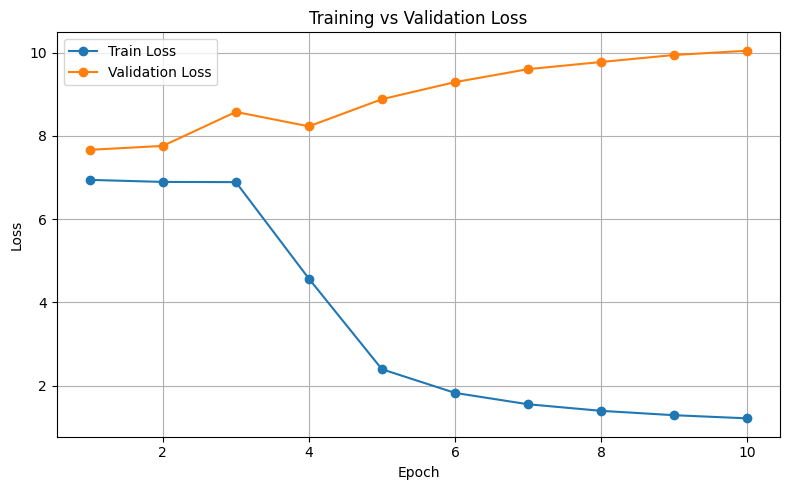

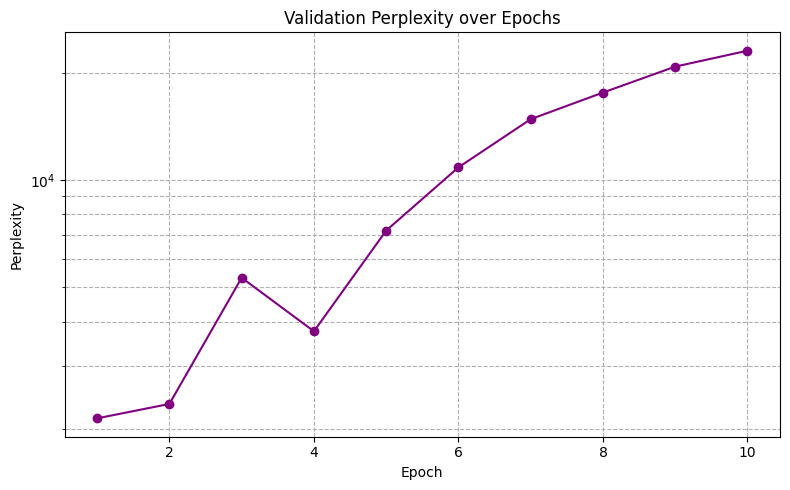

Plots saved in the 'plots' folder.


In [ ]:
os.makedirs("plots", exist_ok=True)

epochs = range(1, len(train_losses) + 1)

plt.figure(figsize=(8,5))
plt.plot(epochs, train_losses, label="Train Loss", marker='o')
plt.plot(epochs, val_losses, label="Validation Loss", marker='o')
plt.title("Training vs Validation Loss")
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.savefig("plots/loss_curve_2x4.png")
plt.show()

plt.figure(figsize=(8,5))
plt.plot(epochs, perplexities, label="Validation Perplexity", color='purple', marker='o')
plt.title("Validation Perplexity over Epochs")
plt.xlabel("Epoch")
plt.ylabel("Perplexity")
plt.yscale("log")
plt.grid(True, which="both", ls="--")
plt.tight_layout()
plt.savefig("plots/perplexity_curve_2x4.png")
plt.show()

print("Plots saved.")